In [53]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import string
import re
import matplotlib.pyplot as plt

In [57]:
import numpy as np
import torch
import os
import torch.nn.functional as F  # Import F for padding

# Path to the directory containing the saved NumPy arrays
NUMPY_DIR = "keystroke_spectrograms/numpy_arrays"

# Function to load all spectrograms from the directory
def load_spectrograms_from_directory(directory):
    spectrograms = []
    keys = []
    widths = []
    filenames = os.listdir(directory)

    # Loop through each file in the directory
    for filename in filenames:
        if filename.endswith('.npy'):
            file_path = os.path.join(directory, filename)

            # Load the NumPy array from file
            spectrogram = np.load(file_path)

            widths.append(spectrogram.shape[1])

            key = re.search(r"keystroke_\d+_([A-Za-z])\.npy", filename).group(1)

            # Convert the spectrogram to a PyTorch tensor
            # Adding a channel dimension (1, height, width) for CNN input
            spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).float()  # Shape: (1, n_freq_bins, n_time_bins)

            # next, add the tensor to a list
            spectrograms.append(spectrogram_tensor)
            keys.append(key)

    return spectrograms, keys, max(widths)

# Load all spectrograms from the specified directory
spectrogram_tensors, keys, max_width = load_spectrograms_from_directory(NUMPY_DIR)

assert len(spectrogram_tensors) == len(keys), "The number of spectrograms and keys do not match!"


## Need to pad the spectrograms to the same width

# Padding function
def pad_tensor(tensor, max_width):
    # Calculate padding size (for the width dimension)
    current_width = tensor.shape[2]  # Index 2 is for the time dimension (width)
    if current_width < max_width:
        padding = max_width - current_width
        # Pad with zeros on the right (width dimension)
        return F.pad(tensor, (0, padding))  # Pad (left, right)
    return tensor

# Apply padding to all spectrograms
for i in range(len(spectrogram_tensors)):
    spectrogram_tensors[i] = pad_tensor(spectrogram_tensors[i], max_width)

# Verify padding
for i, spectrogram in enumerate(spectrogram_tensors):
    print(f"Shape of spectrogram {i}: {spectrogram.shape}")


Shape of spectrogram 0: torch.Size([1, 129, 118])
Shape of spectrogram 1: torch.Size([1, 129, 118])
Shape of spectrogram 2: torch.Size([1, 129, 118])
Shape of spectrogram 3: torch.Size([1, 129, 118])
Shape of spectrogram 4: torch.Size([1, 129, 118])
Shape of spectrogram 5: torch.Size([1, 129, 118])
Shape of spectrogram 6: torch.Size([1, 129, 118])
Shape of spectrogram 7: torch.Size([1, 129, 118])
Shape of spectrogram 8: torch.Size([1, 129, 118])
Shape of spectrogram 9: torch.Size([1, 129, 118])
Shape of spectrogram 10: torch.Size([1, 129, 118])
Shape of spectrogram 11: torch.Size([1, 129, 118])
Shape of spectrogram 12: torch.Size([1, 129, 118])
Shape of spectrogram 13: torch.Size([1, 129, 118])
Shape of spectrogram 14: torch.Size([1, 129, 118])
Shape of spectrogram 15: torch.Size([1, 129, 118])
Shape of spectrogram 16: torch.Size([1, 129, 118])
Shape of spectrogram 17: torch.Size([1, 129, 118])
Shape of spectrogram 18: torch.Size([1, 129, 118])
Shape of spectrogram 19: torch.Size([1, 1

In [46]:
class KeystrokeDataset(Dataset):
    def __init__(self, spectrograms_tensors, labels):
        self.spectrograms = spectrograms_tensors
        self.labels = labels

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]
    
tensors,labels, _ = load_spectrograms_from_directory(NUMPY_DIR)

## convert the keystroke tuple into a tensor
tensors = spectrogram_tensors # adjusting the tensors to the padded spectrograms
alphabet = "abcdefghijklmnopqrstuvwxyz"
char2idx = {char: idx for idx, char in enumerate(alphabet)}
label_indices = [char2idx[char] for char in labels]

label_tensor = torch.tensor(label_indices, dtype=torch.long)

train_dataset = KeystrokeDataset(spectrogram_tensors,label_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Character labels:", labels)
print("Converted Tensor:", label_tensor)

#test_dataset = KeystrokeDataset(test_spectrograms_tensors, test_labels)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Character labels: ['j', 'f', 'u', 'j', 'u', 'f', 'f', 'j', 'l', 'k', 'j', 'p', 'i', 'h', 'y', 'h', 'u', 'u', 'h', 'h', 'i', 'u', 'i', 't', 'o', 'o', 'o', 'u']
Converted Tensor: tensor([ 9,  5, 20,  9, 20,  5,  5,  9, 11, 10,  9, 15,  8,  7, 24,  7, 20, 20,
         7,  7,  8, 20,  8, 19, 14, 14, 14, 20])


In [47]:
class KeystrokeCNN(nn.Module):
    def __init__(self,input_height=129, input_width=101, num_classes=26):
        super(KeystrokeCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, H, W) -> (32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (32, H, W) -> (64, H, W)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (64, H, W) -> (128, H, W)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half (H/2, W/2)

        # Calculate the final feature map size dynamically
        self._to_linear = self._get_conv_output_size(input_height, input_width)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)  
        self.fc2 = nn.Linear(512, num_classes)  # 26 output classes (A-Z)
        #list(string.ascii_lowercase) for generating the output classes

    def _get_conv_output_size(self, height, width):
        """Pass a dummy tensor to determine final feature map size after convolutions"""
        x = torch.zeros(1, 1, height, width)  # Batch size = 1, 1 channel, (H, W)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x.numel()  # Flattened size
    
    def forward(self, x):
        # Forward pass through convolutional layers

        print("size of x",x.shape)  # Debugging the shape before flattening


        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        # Flatten the output from convolutional layers to feed into fully connected layers
        #x = x.view(-1, 128 * 7 * 7)  # Adjust based on input size (H, W)
        x = x.view(x.size(0), -1)  # Flatten dynamically

        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Initialize the model
model = KeystrokeCNN()




In [48]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


size of x torch.Size([28, 1, 129, 101])
[1, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[2, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[3, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[4, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[5, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[6, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[7, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[8, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[9, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[10, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[11, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[12, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[13, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[14, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[15, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[16, 1] loss: 0.000
size of x torch.Size([28, 1, 129, 101])
[17, 1] l

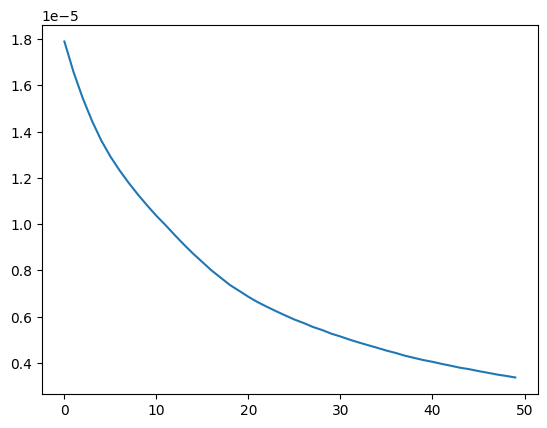

In [54]:
# Function to train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set the model to training mode
    
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            #if i % 200 == 199:  # Print every 200 batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")    

            losses.append(loss.item())

    return losses

# Train the model
epochs = 50
losses = train(model, train_loader, criterion, optimizer, epochs)

plt.plot(range(epochs),losses)
plt.show()


In [67]:
import torch.nn.functional as F

# Define character mapping (should match what you used in training)
letters = "abcdefghijklmnopqrstuvwxyz"
idx2char = {i: c for i, c in enumerate(letters)}

def predict(model, spectrogram_tensor):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # No need to compute gradients
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension (1, 1, 129, 101)
        output = model(spectrogram_tensor)  # Forward pass
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_idx = torch.argmax(probabilities, dim=1).item()  # Get class index
        predicted_letter = idx2char[predicted_idx]  # Convert index to letter
        
    return predicted_letter


def crop_spectrogram(tensor, target_width=101):
    return tensor[:, :, :target_width]  # Keep only the first 101 columns


test_tensor = crop_spectrogram(spectrogram_tensors[5], target_width=101)
print(test_tensor.shape)  # torch.Size([1, 1, 129, 101])

predicted_letter = predict(model, test_tensor)
print(f"Predicted letter: {predicted_letter}")


torch.Size([1, 129, 101])
size of x torch.Size([1, 1, 129, 101])
Predicted letter: j
